In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="XRR8Gd9Xad0UeqknLd7A")
project = rf.workspace("rizqi-oleec").project("nails_segmentation-vhnmw-p6sip-dbjfi")
version = project.version(13)
dataset = version.download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...


In [2]:
import os
import numpy as np
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from tqdm import tqdm

def coco_to_mask(coco_json_path, data_dir, output_mask_dir, class_id_offset=1):  # Changed offset to 1
    """
    Fixed issues:
    1. Changed class_id_offset to 1 (typically background is 0)
    2. Added proper error handling for missing files
    3. Improved mask merging logic
    """
    os.makedirs(output_mask_dir, exist_ok=True)

    try:
        coco = COCO(coco_json_path)
    except:
        print(f"Error loading {coco_json_path}")
        return

    img_ids = coco.getImgIds()
    cat_ids = coco.getCatIds()

    if not cat_ids:
        print(f"No categories found in {coco_json_path}")
        return

    cat_id_to_idx = {cat_id: i + class_id_offset for i, cat_id in enumerate(cat_ids)}

    for img_id in tqdm(img_ids, desc=f"Processing {os.path.basename(data_dir)}"):
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        img_path = os.path.join(data_dir, file_name)

        if not os.path.exists(img_path):
            continue

        width, height = img_info['width'], img_info['height']
        mask = np.zeros((height, width), dtype=np.uint8)
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            if 'segmentation' not in ann:
                continue

            cat_id = ann['category_id']
            class_idx = cat_id_to_idx.get(cat_id, 0)

            try:
                rle = maskUtils.frPyObjects(ann['segmentation'], height, width)
                rle = maskUtils.merge(rle)
                ann_mask = maskUtils.decode(rle)
                mask[ann_mask > 0] = class_idx
            except:
                continue

        mask_name = os.path.splitext(file_name)[0] + ".png"
        cv2.imwrite(os.path.join(output_mask_dir, mask_name), mask)

def clear_and_create_dir(dir_path):
    """Fixed to handle directory clearing safely"""
    if os.path.exists(dir_path):
        for root, dirs, files in os.walk(dir_path, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
    os.makedirs(dir_path, exist_ok=True)

def move_images_to_subfolder(split_dir, image_extensions=('.jpg', '.jpeg', '.png')):
    image_dir = os.path.join(split_dir, 'images')
    os.makedirs(image_dir, exist_ok=True)

    for file_name in os.listdir(split_dir):
        if file_name.lower().endswith(image_extensions):
            old_path = os.path.join(split_dir, file_name)
            new_path = os.path.join(image_dir, file_name)
            os.rename(old_path, new_path)


def process_all_splits(base_dir):
    """Added validation checks"""
    required_splits = ['train', 'valid', 'test']
    available_splits = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for split in required_splits:
        if split not in available_splits:
            print(f"Split {split} not found in dataset")
            continue

        split_dir = os.path.join(base_dir, split)
        coco_json = os.path.join(split_dir, '_annotations.coco.json')
        mask_dir = os.path.join(split_dir, 'masks')

        if not os.path.exists(coco_json):
            print(f"Annotations not found for {split}")
            continue

        move_images_to_subfolder(split_dir)
        clear_and_create_dir(mask_dir)

        # Gunakan folder 'images' sebagai sumber gambar
        image_dir = os.path.join(split_dir, 'images')
        coco_to_mask(coco_json, image_dir, mask_dir)


# Main processing
if __name__ == "__main__":
    base_dataset_path = "/content/nails_segmentation-13"
    process_all_splits(base_dataset_path)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


Processing images: 100%|██████████| 10436/10436 [03:43<00:00, 46.67it/s]


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Processing images: 100%|██████████| 2271/2271 [00:34<00:00, 65.43it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Processing images: 100%|██████████| 103/103 [00:00<00:00, 109.51it/s]


In [3]:
import tensorflow as tf
from tensorflow.keras import backend
import os

image_size = 256
batch_size = 32
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = tf.where(input_mask > 0, 1, 0)
    input_mask = tf.cast(input_mask, tf.int32)
    return input_image, input_mask

def load_image(image_path, mask_path):
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels=1)

    input_image = tf.image.resize(input_image, (image_size, image_size))
    input_mask = tf.image.resize(input_mask, (image_size, image_size), method="nearest")

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    input_mask = tf.squeeze(input_mask, axis=-1)
    return {"pixel_values": input_image, "labels": input_mask}

def create_dataset(image_paths, mask_paths, batch_size=128, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [4]:
dataset_location = "/content/nails_segmentation-13"
train_img_dir = os.path.join(dataset_location, "train", "images")
train_mask_dir = os.path.join(dataset_location, "train", "masks")
test_img_dir = os.path.join(dataset_location, "valid", "images")
test_mask_dir = os.path.join(dataset_location, "valid", "masks")

train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir) if f.endswith('.png')])
test_img_paths = sorted([os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
test_mask_paths = sorted([os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir) if f.endswith('.png')])

train_ds = create_dataset(train_img_paths, train_mask_paths, batch_size=batch_size, shuffle=True)
test_ds = create_dataset(test_img_paths, test_mask_paths, batch_size=batch_size)


In [5]:
for batch in train_ds.take(1):
    print("Image shape:", batch["pixel_values"].shape)
    print("Label shape:", batch["labels"].shape)
    print("Unique labels:", tf.unique(tf.reshape(batch["labels"], [-1]))[0].numpy())


Image shape: (32, 3, 256, 256)
Label shape: (32, 256, 256)
Unique labels: [0 1]


In [6]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 256, 256), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 256, 256), dtype=tf.int32, name=None)}


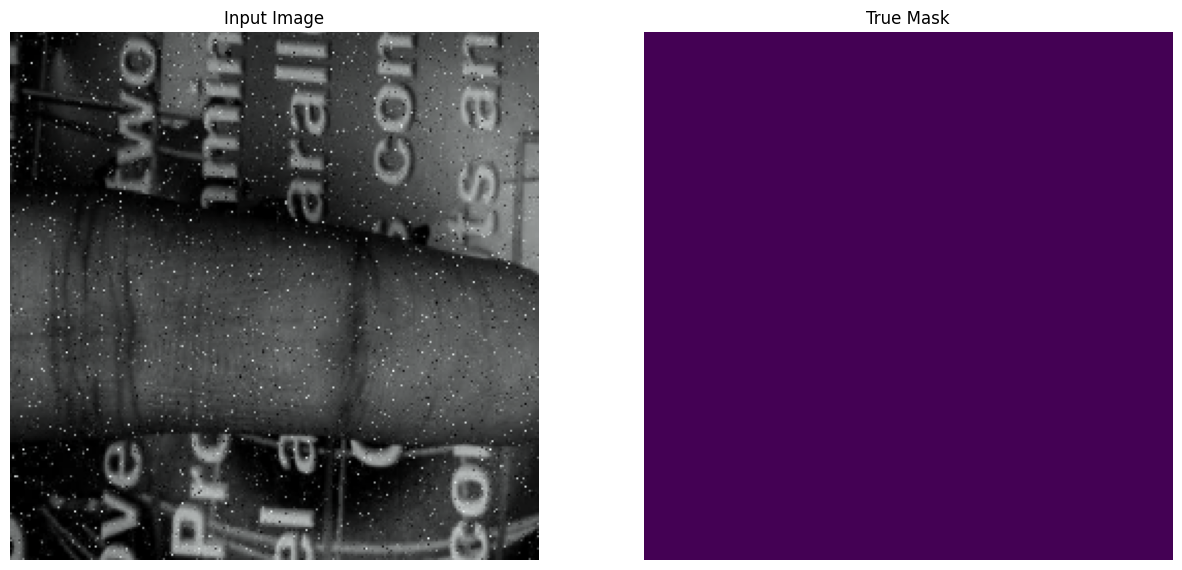

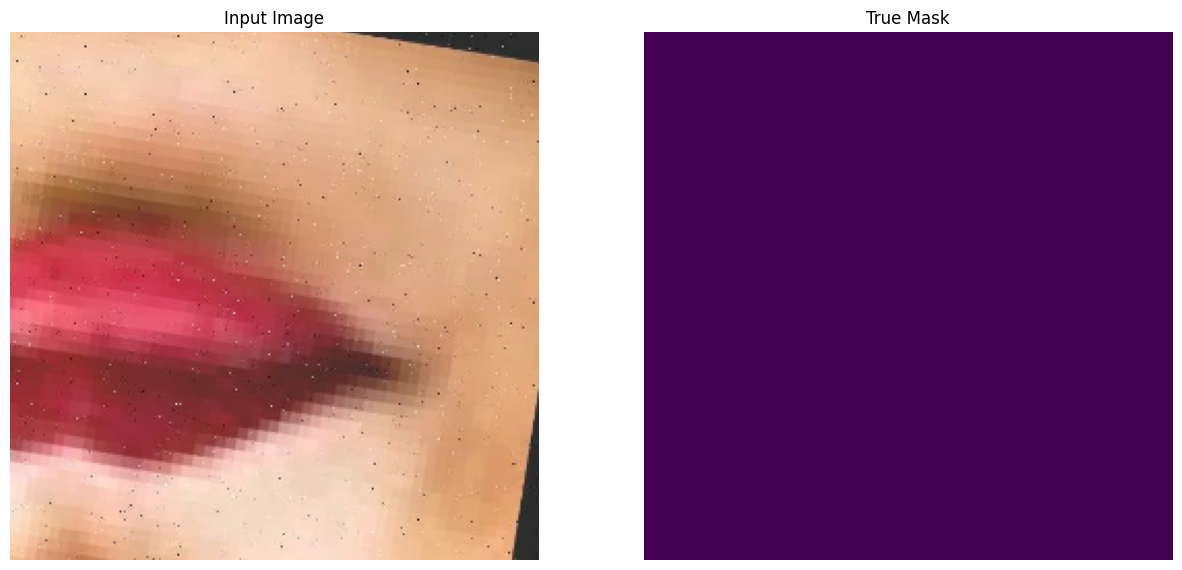

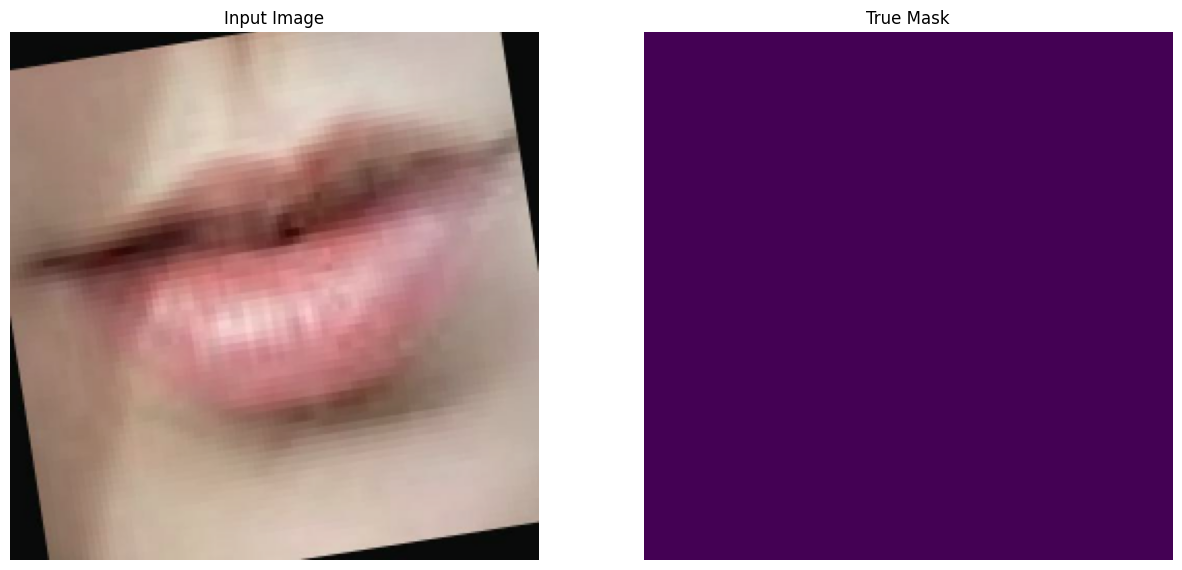

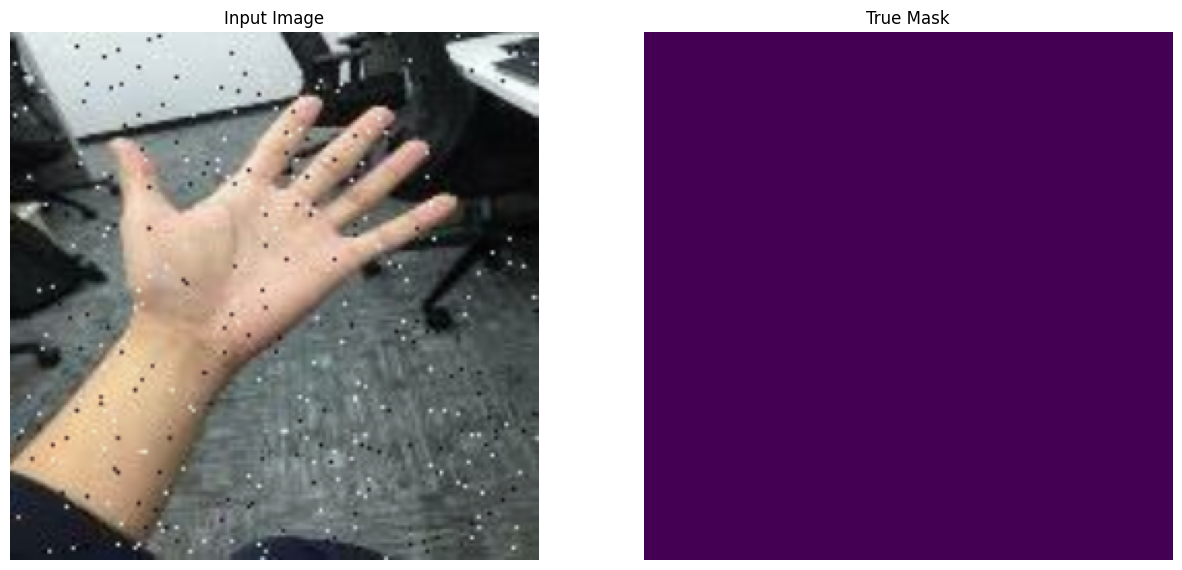

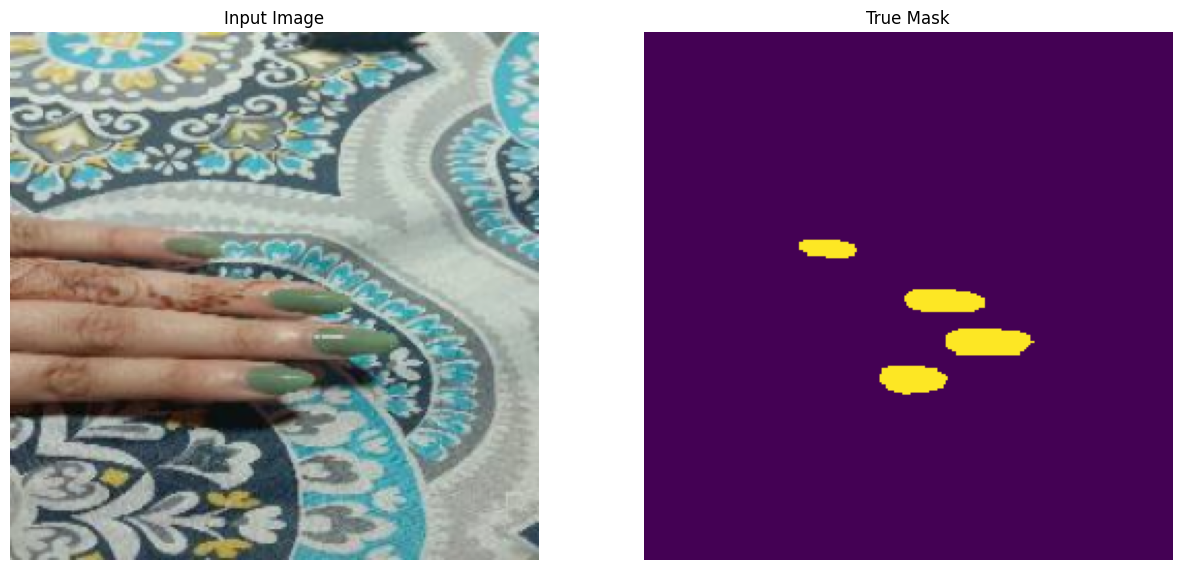

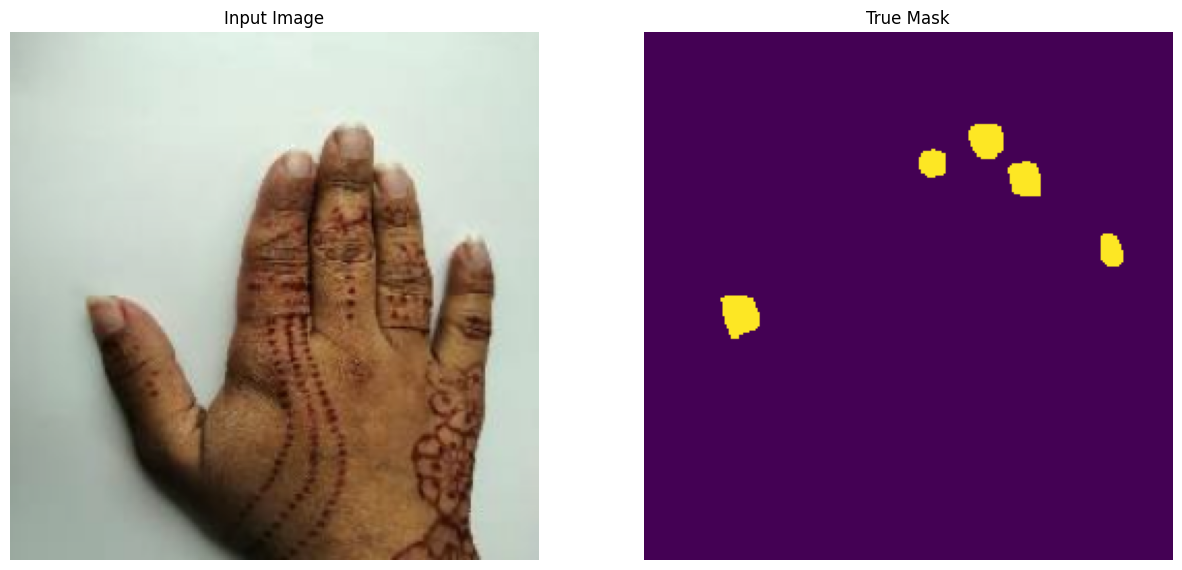

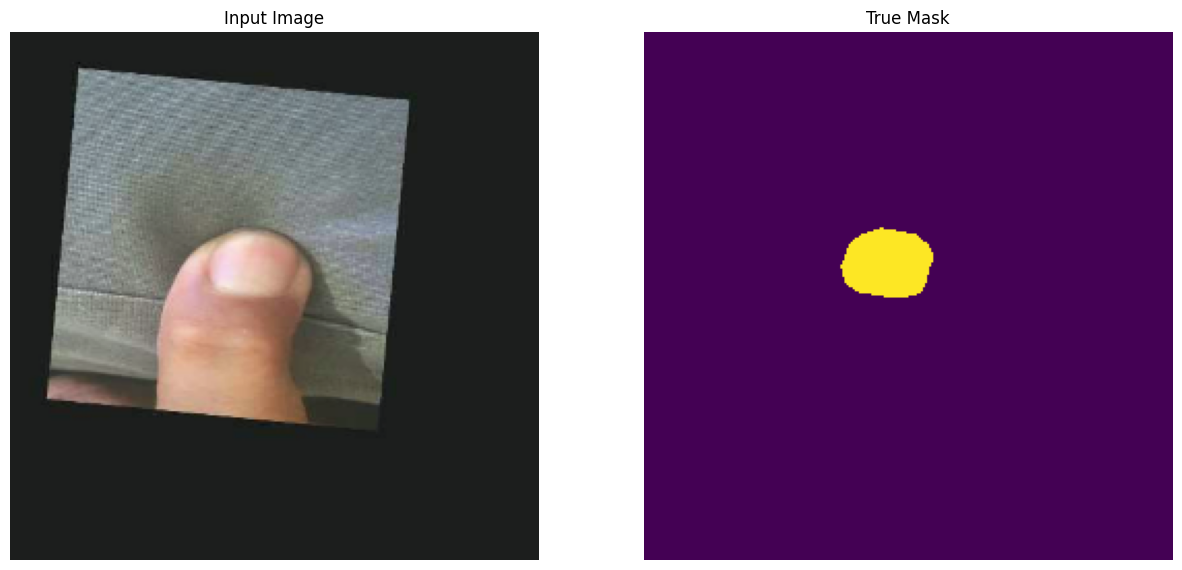

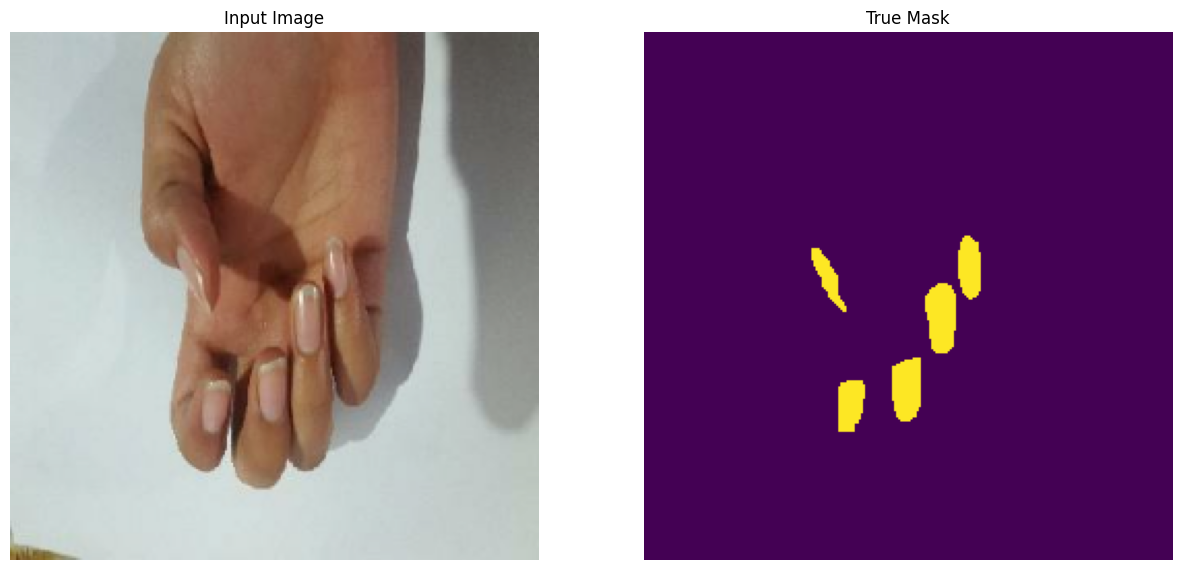

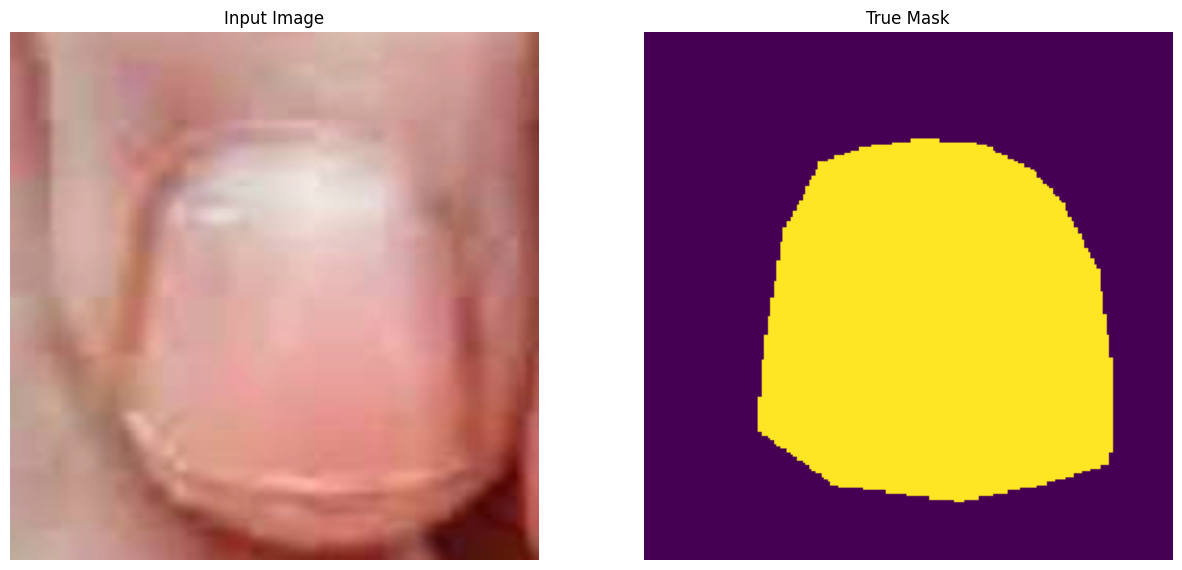

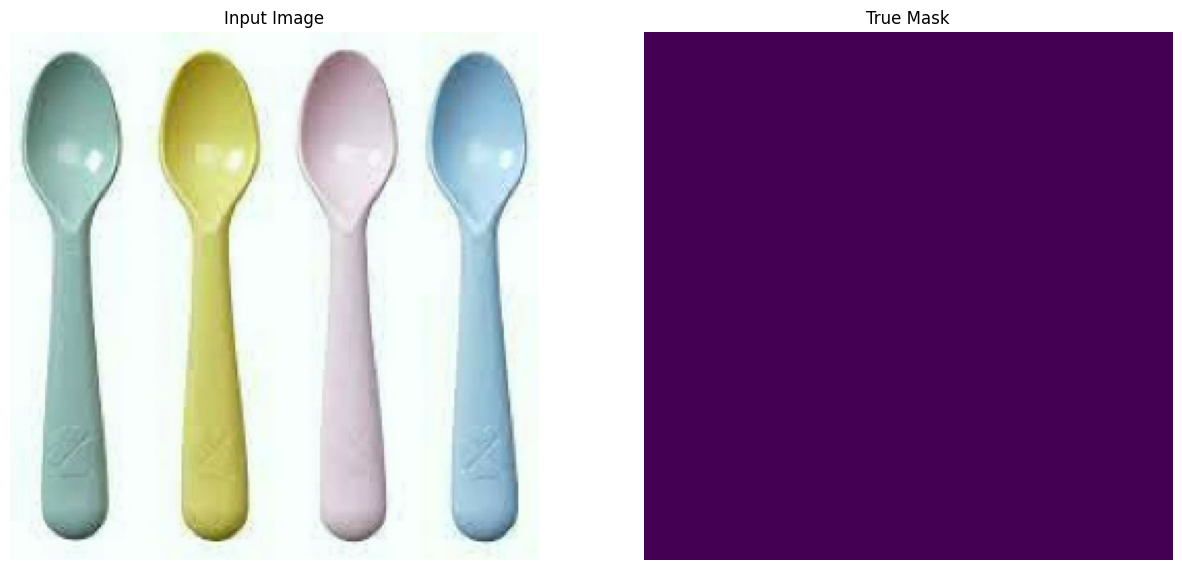

In [7]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(10):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [8]:
import tensorflow as tf
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "background", 1: "nail"}
label2id = {v: k for k, v in id2label.items()}

base_model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Buat model wrapper dengan resize output ke (256, 256)
class SegFormerWithResize(tf.keras.Model):
    def __init__(self, base_model, drop_prob=None, **kwargs): # Pass base_model as argument
        super().__init__(**kwargs)
        self.base_model = base_model # Assign base_model as a layer
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        x = self.base_model(x, training=training).logits # Call the base model
        if self.drop_prob == 0.0 or not training:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
        random_tensor = tf.floor(random_tensor)
        output = tf.math.divide(x, keep_prob) * random_tensor
        return output

# Initialize the model with the base model and dropout probability
model = SegFormerWithResize(base_model=base_model, drop_prob=0.0)



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificati

In [9]:
learning_rate = 0.00006
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["sparse_categorical_accuracy"],
    run_eagerly=True
)


In [10]:
from IPython.display import clear_output

def create_mask(pred_mask):
    """Create a mask from model prediction logits."""
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]

def display(display_list):
    """Display image, ground truth, and prediction."""
    title = ["Input Image", "True Mask", "Predicted Mask"]
    plt.figure(figsize=(15, 5))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        image = tf.keras.utils.array_to_img(display_list[i])
        plt.imshow(image, cmap="gray" if i > 0 else None)
        plt.axis("off")
    plt.show()

def show_predictions(dataset=None, num=1):
    """Visualize predictions from dataset or sample image."""
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images, verbose=0).logits
            images = tf.transpose(images, (0, 2, 3, 1))  # CHW -> HWC
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        try:
            image_input = tf.expand_dims(sample_image, 0)
            pred_mask = model.predict(image_input, verbose=0).logits
            display([sample_image, sample_mask, create_mask(pred_mask)])
        except NameError:
            print("Error: sample_image and sample_mask need to be defined.")

class DisplayCallback(tf.keras.callbacks.Callback):
    """Display prediction after each epoch."""
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print(f"\nSample Prediction after epoch {epoch + 1}")
        if logs:
            for metric, value in logs.items():
                print(f"{metric}: {value:.4f}")

    def _implements_train_batch_hooks(self): return False
    def _implements_test_batch_hooks(self): return False
    def _implements_predict_batch_hooks(self): return False

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
)


Epoch 1/5


In [16]:
show_predictions(test_ds, 5)

AttributeError: 'numpy.ndarray' object has no attribute 'logits'

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)